### Practice: Voice Command Recognition

![img](https://yastatic.net/s3/lpc/bf4f0ad7-739e-4e52-a370-ec173244aa6c.png)

Today you're finally gonna deal with speech! We'll walk you through all the main steps of speech processing pipeline and you'll get to write your own voice recognition system. It's gonna be fun! _(they said)_

In [ ]:
from IPython.display import display, Audio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import librosa

!wget https://github.com/yandexdataschool/nlp_course/raw/2019/week10_asr/sample1.wav -O sample1.wav
!wget https://github.com/yandexdataschool/nlp_course/raw/2019/week10_asr/sample2.wav -O sample2.wav
display(Audio("sample1.wav"))
display(Audio("sample2.wav"))

--2023-12-06 15:15:21--  https://github.com/yandexdataschool/nlp_course/raw/2019/week10_asr/sample1.wav
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yandexdataschool/nlp_course/2019/week10_asr/sample1.wav [following]
--2023-12-06 15:15:21--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/2019/week10_asr/sample1.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 696398 (680K) [audio/wav]
Saving to: ‘sample1.wav’

sample1.wav         100%[===================>] 680.08K  --.-KB/s    in 0.07s   

2023-12-06 15:15:22 (9.14 MB/s) - ‘sample1.wav’ saved [696398/696398]

--2023-12-06 15

Consider an audio sample above. The reason you can hear a sound is because your speakers/headphones cause oscillations of air that reach your ears. There's a part of your inner ear called [Cochlea](https://en.wikipedia.org/wiki/Cochlea) that looks like a spiral where every spot is receptive to a specific range of sound frequency.
![img](https://i.pinimg.com/originals/f7/ed/7e/f7ed7eeb0c4e45b9a35dff9465805b48.jpg)

The sound itself can be recorded as a collection of __amplitudes__ of these oscillations over time:

Length: 3.947392290249433 seconds at sample rate 22050


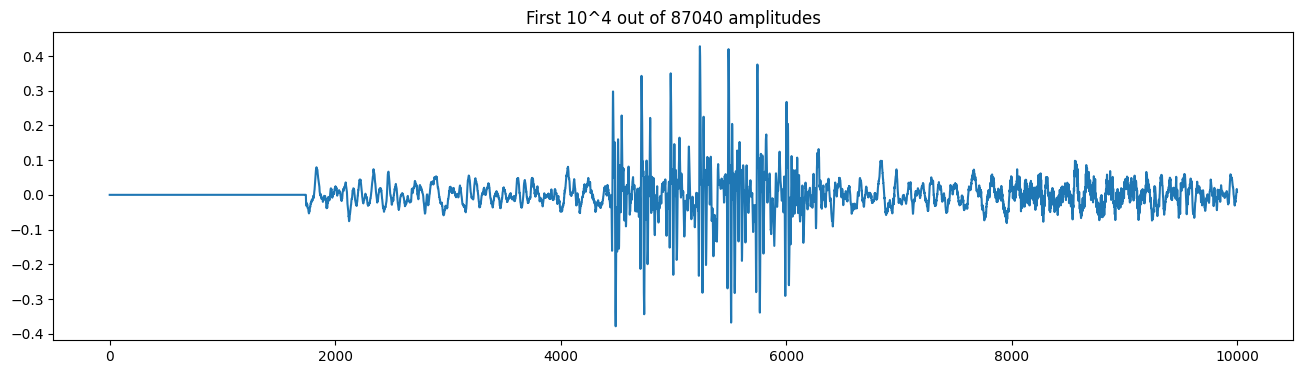

In [ ]:
amplitudes, sample_rate = librosa.core.load("./sample1.wav")

print("Length: {} seconds at sample rate {}".format(amplitudes.shape[0] / sample_rate, sample_rate))
plt.figure(figsize=[16, 4])
plt.title("First 10^4 out of {} amplitudes".format(len(amplitudes)))
plt.plot(amplitudes[:10000]);

### Task 1: Mel-Spectrogram (5 points)

As you can see, amplitudes follow a periodic patterns with different frequencies. However, it is very difficult to process these amplitudes directly because there's so many of them! A typical WAV file contains 22050 amplitudes per second, which is already way above a typical sequence length for other NLP applications. Hence, we need to compress this information to something manageable.

A typical solution is to use __spectrogram:__ instead of saving thousands of amplitudes, we can perform Fourier transformation to find which periodics are prevalent at each point in time. More formally, a spectrogram applies [Short-Time Fourier Transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to small overlapping windows of the amplitude time-series:

<img src="https://www.researchgate.net/profile/Phillip_Lobel/publication/267827408/figure/fig2/AS:295457826852866@1447454043380/Spectrograms-and-Oscillograms-This-is-an-oscillogram-and-spectrogram-of-the-boatwhistle.png" width="480px">

However, this spectrogram may have extraordinarily large numbers that can break down neural networks. Therefore the standard approach is to convert spectrogram into a __mel-spectrogram__ by changing frequencies to [Mel-frequency spectrum(https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)].

Hence, the algorithm to compute spectrogram of amplitudes $y$ becomes:
1. Compute Short-Time Fourier Transform (STFT): apply fourier transform to overlapping windows
2. Build a spectrogram: $S_{ij} = abs(STFT(y)_{ij}^2)$
3. Convert spectrogram to a Mel basis


By far the hardest pard of this is computing STFT, so let's focus on that first:
1.

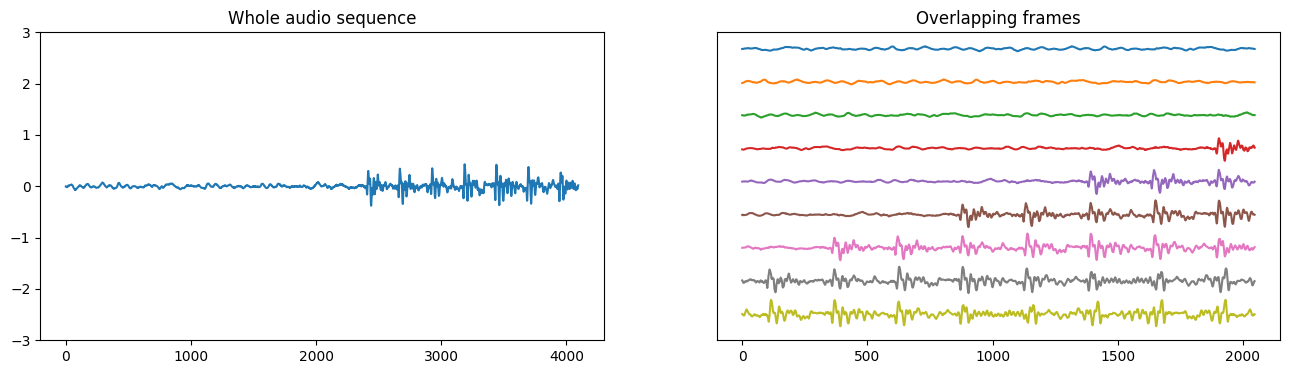

In [ ]:
# Some helpers:
# 1. slice time-series into overlapping windows
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)



dummy_amps = amplitudes[2048: 6144]
dummy_frames = slice_into_frames(dummy_amps, 2048, 512)

plt.figure(figsize=[16, 4])
plt.subplot(121, title='Whole audio sequence', ylim=[-3, 3])
plt.plot(dummy_amps)

plt.subplot(122, title='Overlapping frames', yticks=[])
for i, frame in enumerate(dummy_frames.T):
    plt.plot(frame + 10 - i);

In [ ]:
dummy_frames.shape

(2048, 9)

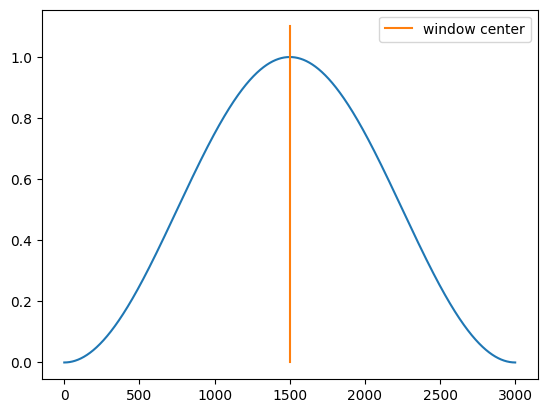

In [ ]:
dummy_window_length = 3000
import librosa
dummy_weights_window = librosa.filters.get_window('hann', dummy_window_length, fftbins=True)

plt.plot(dummy_weights_window); plt.plot([1500, 1500], [0, 1.1], label='window center'); plt.legend()

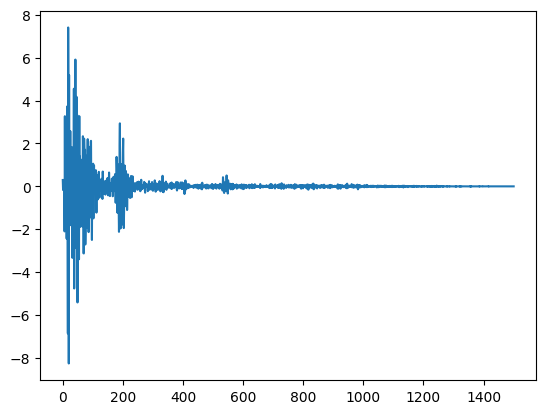

In [ ]:
# 3. Fast Fourier Transform in Numpy. Note: this function can process several inputs at once (mind the axis!)
dummy_fft = np.fft.rfft(dummy_amps[:3000, None] * dummy_weights_window[:, None], axis=0)  # complex[sequence_length, num_sequences]
plt.plot(np.real(dummy_fft)[:, 0])

Okay, now it's time to combine everything into a __S__hort-__T__ime __F__ourier __T__ransform

In [ ]:
import scipy.signal

def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # slice amplitudes into overlapping frames [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)

    # get weights for Fourier transform, float[window_length]
    fft_weights = librosa.filters.get_window('hann', window_length, fftbins=True)

    # apply Fourier transform to frames scaled by weights
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft





In [ ]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes], time-series of sound amplitude, same as above
    :param sample_rate: num amplitudes per second
    :param n_mels: spectrogram channels
    :param window_length: length of a patch to which you apply FFT
    :param hop_length: interval between consecutive windows
    :param f_min: minimal frequency
    :param f_max: maximal frequency
    :returns: mel-spectrogram [n_mels, duration]
    """
    # Step I: compute Short-Time Fourier Transform
    stft = get_STFT(amplitudes, window_length, hop_length)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // hop_length + 1)

    # Step II: convert stft to a spectrogram
    spectrogram = np.abs(stft)**2

    # Step III: convert spectrogram into Mel basis (multiplying by transformation matrix)
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]

    mel_spectrogram = np.dot(mel_basis, spectrogram)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // hop_length + 1)

    return mel_spectrogram




In [ ]:
amplitudes1, _ = librosa.core.load("./sample1.wav")
amplitudes2, _ = librosa.core.load("./sample2.wav")
ref1 = librosa.feature.melspectrogram(y=amplitudes1, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
ref2 = librosa.feature.melspectrogram(y=amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
assert np.allclose(get_melspectrogram(amplitudes1), ref1, rtol=1e-4, atol=1e-4)
assert np.allclose(get_melspectrogram(amplitudes2), ref2, rtol=1e-4, atol=1e-4)

AssertionError: ignored

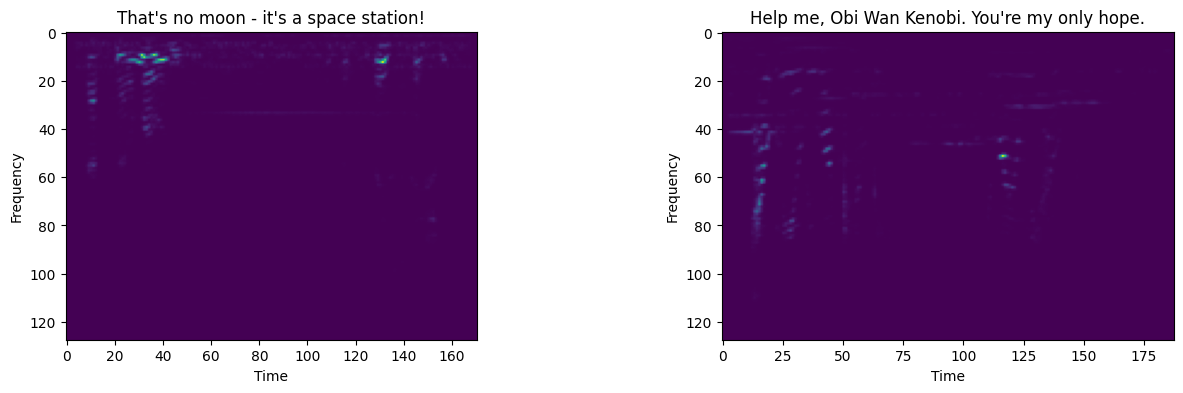

In [ ]:
plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("That's no moon - it's a space station!"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes1))

plt.subplot(1, 2, 2)
plt.title("Help me, Obi Wan Kenobi. You're my only hope."); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes2));

# note that the second spectrogram has higher mean frequency corresponding to the difference in gender

### Speech Commands Dataset

We're now going to train a classifier to recognize voice. More specifically, we'll use the [Speech Commands Dataset]  that contains around 30 different words with a few thousand voice records each. Naturally, we'll preprocess each training sample using the `get_melspectrogram` you designed.

In [ ]:
import os
datadir = "speech_commands"

!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls))]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

--2023-12-06 15:24:42--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.215.207, 173.194.216.207, 173.194.217.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.215.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   255MB/s    in 9.6s    

2023-12-06 15:24:51 (148 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


Let's begin by training a model to recognize direcions. Imagine a mobile robot that you can control via speech. You say "Go right" and it obeys. Or it doesn't - depending on how you trained it :)

In [ ]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm
import joblib as jl

classes = ("left", "right", "up", "down", "stop")

def preprocess_sample(filepath, max_length=150):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = get_melspectrogram(amplitudes, sample_rate=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = classes.index(filepath.split(os.sep)[-2])
    return np.float32(spectrogram), np.int64(target)

all_files = chain(*(samples_by_target[cls] for cls in classes))
spectrograms_and_targets = jl.Parallel(n_jobs=-1)(tqdm(list(map(jl.delayed(preprocess_sample), all_files))))
X, y = map(np.stack, zip(*spectrograms_and_targets))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

100%|██████████| 11834/11834 [02:05<00:00, 94.35it/s] 


__Train a model: (5points)__ finally, lets' build and train a classifier neural network. You can use _any_ library you like. If in doubt, consult the model & training tips below.

In [ ]:
import keras, keras.layers as L

# Build, compile and train a model. If you're out of ideas, see hints below
# Use any framework you want, the stub below is optional
model = keras.models.Sequential([
    L.InputLayer(input_shape=(None, 128)),  # (batch), time, channels
    <YOUR CODE>
])

# Compile and train
<YOUR CODE>

In [ ]:
import keras, keras.layers as L
model = keras.Sequential([
    L.InputLayer(input_shape=(None, 128)),  # (batch), time, channels

    # Convolutional block 1
    L.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=2),
    L.Dropout(0.3),

    # Convolutional block 2
    L.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=2),
    L.Dropout(0.3),

    # Flattening the output to feed into a Dense layer
    L.GlobalMaxPooling1D(),

    # Dense classifier
    L.Dense(128, activation='relu'),
    L.Dropout(0.5),
    L.Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)


In [ ]:
import keras, keras.layers as L, keras.callbacks as Callbacks

class EarlyStoppingAtAccuracy(Callbacks.Callback):
    def __init__(self, target_accuracy):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy', 0) >= self.target_accuracy:
            print(f"\nReached {self.target_accuracy * 100}% accuracy so stopping training!")
            self.model.stop_training = True

# Assuming 'classes' is defined and includes all your target classes
num_classes = len(classes)

early_stopping_callback = EarlyStoppingAtAccuracy(target_accuracy=0.85)

# Train the model with the custom callback
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping_callback]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy}")


Epoch 1/100
277/278 [============================>.] - ETA: 0s - loss: 0.4466 - accuracy: 0.8408
Reached 85.0% accuracy so stopping training!
93/93 [==============================] - 2s 17ms/step - loss: 0.3966 - accuracy: 0.8581
Validation accuracy: 0.8580601811408997


In [ ]:
"""
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=100
)

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy}")"""


'\nhistory = model.fit(\n    X_train, y_train,\n    validation_data=(X_val, y_val),\n    batch_size=16,  \n    epochs=100 \n)\n\nval_loss, val_accuracy = model.evaluate(X_val, y_val)\nprint(f"Validation accuracy: {val_accuracy}")'

In [ ]:
accuracy = np.mean(model.predict(X_val).argmax(-1) == y_val)
print("Final Accuracy:", accuracy)
assert accuracy >= 0.85, "Your model is not good enough. Yet."
print("Well done!")

93/93 [==============================] - 1s 15ms/step
Final Accuracy: 0.858060155457925
Well done!


__Training tips:__ here's what you can try:
* __Layers:__ 1d or 2d convolutions, perhaps with some batch normalization in between;
* __Architecture:__ VGG-like, residual, highway, densely-connected - you name it :)
* __Batch size matters:__ smaller batches usually train slower but better. Try to find the one that suits you best.
* __Data augmentation:__ add background noise, faster/slower, change pitch;
* __Average checkpoints:__ you can make model more stable with [this simple technique (arxiv)](https://arxiv.org/abs/1803.05407)
* __For full scale stage:__ make sure you're not losing too much data due to max_length in the pre-processing stage!

These are just recommendations. As long as your model works, you're not required to follow them.

### Optional: full scale recognition (4+ points)

Your final task is to train a full-scale voice command spotter and apply it to a video:
1. Build the dataset with all 30+ classes (directions, digits, names, etc.)
  * __Optional:__ include a special "noise" class that contains random unrelated sounds
  * You can download youtube videos with [`youtube-dl`](https://ytdl-org.github.io/youtube-dl/index.html) library.
2. Train a model on this full dataset. Kudos for tuning its accuracy :)
3. Apply it to a audio/video of your choice to spot the occurences of each keyword
 * Here's one [video about primes](https://www.youtube.com/watch?v=EK32jo7i5LQ) that you can try. It should be full of numbers :)
 * There are multiple ways you can analyze the performance of your network, e.g. plot probabilities predicted for every time-step. Chances are you'll discover something useful about how to improve your model :)


As usual, please briefly describe what you did in a short informal report.

In [ ]:
!pip install youtube-dl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.3 MB/s eta 0:00:00


In [ ]:
#<A WHOLE LOT OF YOUR CODE>

In [ ]:
import youtube_dl

ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '192',
    }],
    'postprocessor_args': [
        '-ar', '16000'
    ],
    'prefer_ffmpeg': True,
    'keepvideo': False,
}

video_url = 'https://www.youtube.com/watch?v=JWybsoGx5UY&pp=ygUKc21hbGwgdGFsaw%3D%3D'

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    #ydl.download([video_url])
    pass

